<a href="https://colab.research.google.com/github/Tan2306/LSTM-GRU-Conv1D---Temperature-simple-and-multivariate-prediction/blob/main/LSTM_time_forecasting_Temperature_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference - https://www.youtube.com/watch?v=c0k-YLQGKjY&t=1165s

# Importing required libraries and modules

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint # This is to save the model that perform best on the validation set
from tensorflow.keras.losses import MeanSquaredError # The loss function
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error as mse
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR) # to kill the warnings that pop up while training models


# Getting the data from keras datasets

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
df.head()

13582336/13568290 [==============================] - 0s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3



# Reducing the size of the dataset. 


This dataset has an entry every 10 minutes thus taking every 6th entry will correspond to a reading every hour. Let us start from the 5th entry to have our readings start from 00:00:00, 01.01.2009.

In [ ]:
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


# Plotting the column "T (degC)" with the datetime column.

In [ ]:
df['Date Time'] = pd.to_datetime(df['Date Time'],format='%d.%m.%Y %H:%M:%S')  # converting the date time column to a suitable format

Text(0.5, 1.0, 'Variation of temperature')

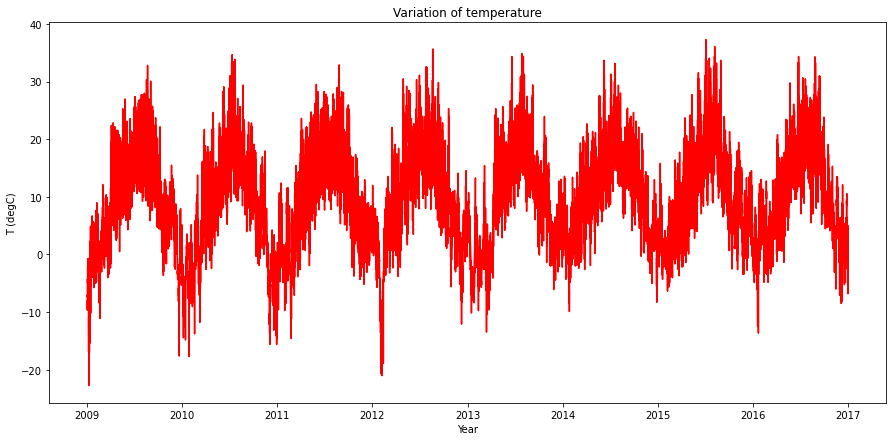

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(df['Date Time'],df['T (degC)'], color='red')
plt.xlabel('Year')
plt.ylabel('T (degC)')
plt.title("Variation of temperature")

# Model 1
#### LSTM applied only on the temperature attribute. It is an example of a simple time series forecasting.

Normally in deep learning, you need the input to be in a certain form, mostly a matrix form with many dimensions. Sometimes, you can even have 3D or 4D tensors.
For an LSTM model, we need to decide how many of the previous values should be used for the prediction of the current value. For the sake of simplicity, let us decide on 5 this and all the subsequent models.

In [ ]:
wind_size=5

If we denote entries with serial numbers then out input will look something like this-



```
X =                      Y
[[[1],[2],[3],[4],[5]]] [6] 
[[[2],[3],[4],[5],[6]]] [7]
[[[3],[4],[5],[6],[7]]] [8]


```

We are making a forecasting problem into a supervised learning problem.
Below is the function for the converting the input into a suitable format for the LSTM model. 


In [ ]:
def input_formatter1(df,window_size=5):   # window size means how many of the consecutive previous values are you taking
  df_as_np = df.to_numpy() # converting dataframe to numpy
  X = []
  Y = []
  for i in range(len(df_as_np)-window_size):
    row=[[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    Y.append(df_as_np[i+5])
  return np.array(X), np.array(Y)

The shape of X might be a bit confusing but the thumb rule is that every individual value (for 1 timestamp) needs to be in a separate bracket. So the 5 lag values needs to be a list of 5 one value list. And then the whole thing needs to be in a list. 

Now let us feed the data to the input_formatter. Make a special note on the shape of X1. 

In [ ]:
X1,Y1 = input_formatter1(df['T (degC)'],5) # 5 is the window size
print("X shape=", X1.shape)
print("Y shape=",Y1.shape)

X shape= (70086, 5, 1)
Y shape= (70086,)


Now we will split the data into training, validation and testing sets. Make sure you do not jumble up the records. The sequence is very important here. You cannot shuffle the data here.


In [ ]:
X1_train,Y1_train=X1[:60000], Y1[:60000]
X1_val, Y1_val = X1[60000:65000], Y1[60000:65000]
X1_test, Y1_test = X1[65000:], Y1[65000:]
print ("Shape of the training input = ", X1_train.shape)

Shape of the training input =  (60000, 5, 1)


In [ ]:
model1 = Sequential()
model1.add(InputLayer((wind_size,1))) # Pay attention to the imput layer shape. Compare it with X_train.shape
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear')) # As we are trying to predict a linear value

model1.summary() # This is used to see the layers and cross check if the output shape at the end (dense_3) is 1 or not, as we are predicting only one value

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/',save_best_only=True) # only save the model which has lowest loss values
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) 

In [ ]:
model1.fit(X1_train, Y1_train, validation_data=(X1_val,Y1_val), 
          epochs=1, #How many runs it has had on the data
          callbacks=[cp1]) # To make sure it calls cp after evey epoch to see if the model should be saved or not.

1875/1875 [==============================] - 17s 8ms/step - loss: 33.1827 - root_mean_squared_error: 5.7604 - val_loss: 1.3252 - val_root_mean_squared_error: 1.1512


So here, it has many models with many different errors and loss. The "model1" identifier currently has the last model it ran and not the best model. So to load that up, we use the following command.

In [ ]:
model1 = load_model('model1/')

To automate the code to plot predicted and actual values for the training, validation and testing sets, this function was made.

In [ ]:
def plot_predictions1(model,X,Y,start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions,"Actuals":Y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  plt.xlabel('Serial No.')
  plt.ylabel('Temperature')
  return df, mse(Y,predictions)

Plotting the training data predictions and actual values and then the same for the validation and testing sets.

(       Predictions  Actuals
 0        -4.020613    -9.67
 1        -4.040000    -9.17
 2        -4.060068    -8.10
 3        -4.087640    -7.66
 4        -4.073408    -7.04
 ...            ...      ...
 59995     4.800660     6.07
 59996     7.463879     9.88
 59997    11.562741    13.53
 59998    15.256411    15.43
 59999    16.253471    15.54
 
 [60000 rows x 2 columns], 4.401621541246536)

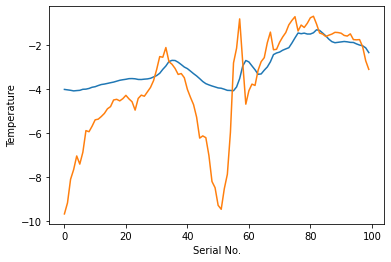

In [ ]:
plot_predictions1(model1,X1_train,Y1_train)

(      Predictions  Actuals
 0       15.862345    14.02
 1       14.079723    13.67
 2       13.543207    12.27
 3       12.147369    11.19
 4       11.094381    10.85
 ...           ...      ...
 4995    19.180288    18.27
 4996    18.411552    17.85
 4997    17.896624    16.65
 4998    16.855202    15.85
 4999    15.891182    15.09
 
 [5000 rows x 2 columns], 1.325207110050719)

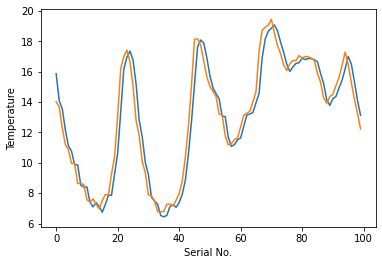

In [ ]:
plot_predictions1(model1,X1_val,Y1_val)

(      Predictions  Actuals
 0       15.004850    13.99
 1       13.869854    13.46
 2       13.319894    12.93
 3       12.808607    12.43
 4       12.328307    12.17
 ...           ...      ...
 5081    -0.421272    -0.98
 5082    -0.831348    -1.40
 5083    -1.031243    -2.75
 5084    -1.635200    -2.89
 5085    -2.184929    -3.93
 
 [5086 rows x 2 columns], 4.910788382446581)

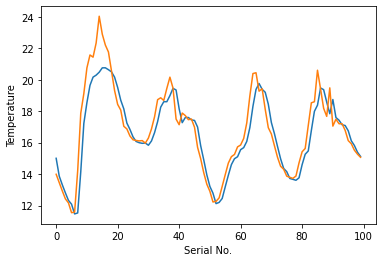

In [ ]:
plot_predictions1(model1,X1_test,Y1_test)

# Model 2
#### CNN with a simple time series forcasting (only using the temperature variable).

Normally RNN is always associated with forecasting and NLP. CNN are always associated with images but that is not always true, you can have 1D matrix instead of 2D. CNN are much simpler than RNN so let us use that in time forecasting.
<br>
So now we will be making a CNN model for time forecasting. We copy the last LSTM code and replace LSTM with Conv1D. This is still a simple time series prediction which is only considering the temperature feature. 

In [ ]:
model2 = Sequential()
model2.add(InputLayer((wind_size,1))) # Pay attention to the input layer shape. Compare it with X_train.shape
model2.add(Conv1D(64,kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear')) # As we are trying to predict a linear value

model2.summary() # This is used to see the layers and cross check if the output shape at the end (dense_3) is 1 or not, as we are predicting only one value

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('model2/',save_best_only=True) # only save the model which has lowest loss values
model2.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) 

Here we have not made a new input_formatter or X2 or Y2 to divide them into training, validation and testing sets. The ones from model1 work perfectly fine as the input shape has to be the same.

In [ ]:
model2.fit(X1_train, Y1_train, validation_data=(X1_val,Y1_val), 
          epochs=1, #How many runs it has had on the data
          callbacks=[cp2]) # To make sure it calls cp after evey epoch to see if the model should be saved or not.

1875/1875 [==============================] - 5s 2ms/step - loss: 7.1559 - root_mean_squared_error: 2.6751 - val_loss: 2.0573 - val_root_mean_squared_error: 1.4343


In [ ]:
model2 = load_model('model2/')

We will also be using the plot_predictions1 as the format of tje data is the same.

(       Predictions  Actuals
 0        -0.085736    -9.67
 1        -0.085736    -9.17
 2        -0.085736    -8.10
 3        -0.085736    -7.66
 4        -0.085736    -7.04
 ...            ...      ...
 59995     5.119730     6.07
 59996     6.908563     9.88
 59997    10.672206    13.53
 59998    14.813601    15.43
 59999    17.326275    15.54
 
 [60000 rows x 2 columns], 4.995332701524831)

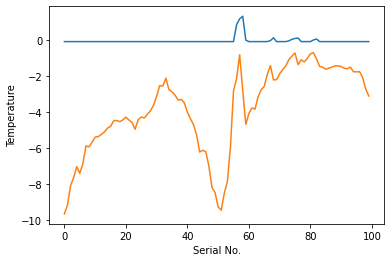

In [ ]:
plot_predictions1(model2,X1_train,Y1_train)

(      Predictions  Actuals
 0       17.317070    14.02
 1       14.996158    13.67
 2       13.554120    12.27
 3       11.864229    11.19
 4       10.739079    10.85
 ...           ...      ...
 4995    18.685890    18.27
 4996    17.824169    17.85
 4997    17.019405    16.65
 4998    16.236450    15.85
 4999    15.437292    15.09
 
 [5000 rows x 2 columns], 2.0573343407732407)

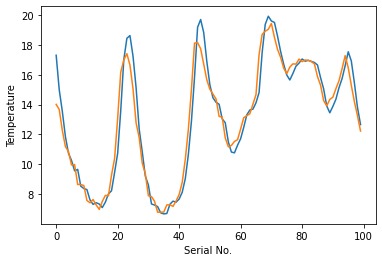

In [ ]:
plot_predictions1(model2,X1_val,Y1_val)

(      Predictions  Actuals
 0       14.533166    13.99
 1       13.524335    13.46
 2       12.949762    12.93
 3       12.464773    12.43
 4       12.105327    12.17
 ...           ...      ...
 5081     0.273893    -0.98
 5082     0.020985    -1.40
 5083    -0.201436    -2.75
 5084    -0.155409    -2.89
 5085    -0.085736    -3.93
 
 [5086 rows x 2 columns], 1.862526789022447)

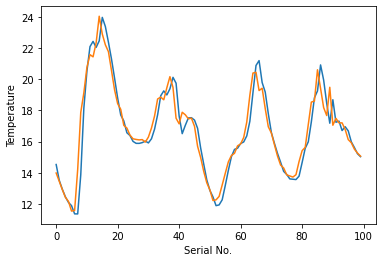

In [ ]:
plot_predictions1(model2,X1_test,Y1_test)

# Model 3
We will be using GRU (Gated Recurrent Unit). It is a type of RNN. GRU is findamentally more like LSTM that Conv1D. It can be thought of as a simpler LSTM.

In [ ]:
model3 = Sequential()
model3.add(InputLayer((wind_size,1)))
model3.add(GRU(64))
model3.add(Dense(8,'relu'))
model3.add(Dense(1,'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp3 = ModelCheckpoint('model3/',save_best_only=True)
model3.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])

As again, we do not have a change of format of the input, we can continue using X1 and Y1.

In [ ]:
model3.fit(X1_train, Y1_train, validation_data=(X1_val,Y1_val), 
          epochs=1, #How many runs it has had on the data
          callbacks=[cp3]) # To make sure it calls cp after evey epoch to see if the model should be saved or not.

1875/1875 [==============================] - 15s 7ms/step - loss: 46.3602 - root_mean_squared_error: 6.8088 - val_loss: 1.6602 - val_root_mean_squared_error: 1.2885


In [ ]:
model3 = load_model('model3/')

(       Predictions  Actuals
 0        -8.855218    -9.67
 1        -9.015677    -9.17
 2        -8.957032    -8.10
 3        -8.632148    -7.66
 4        -8.315305    -7.04
 ...            ...      ...
 59995     7.219773     6.07
 59996     9.021466     9.88
 59997    11.415808    13.53
 59998    14.368063    15.43
 59999    15.527028    15.54
 
 [60000 rows x 2 columns], 7.176831504691759)

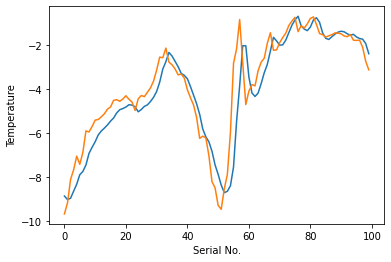

In [ ]:
plot_predictions1(model3,X1_train,Y1_train)

(      Predictions  Actuals
 0       15.547194    14.02
 1       14.356339    13.67
 2       13.666394    12.27
 3       12.306691    11.19
 4       10.904452    10.85
 ...           ...      ...
 4995    16.724428    18.27
 4996    16.684389    17.85
 4997    16.593796    16.65
 4998    16.169844    15.85
 4999    15.716003    15.09
 
 [5000 rows x 2 columns], 1.6602266147066715)

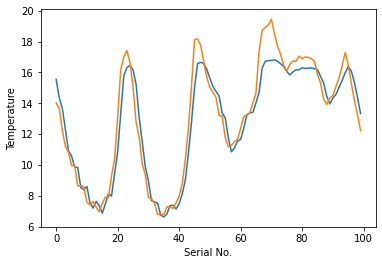

In [ ]:
plot_predictions1(model3,X1_val,Y1_val)

(      Predictions  Actuals
 0       15.158954    13.99
 1       14.184216    13.46
 2       13.472054    12.93
 3       12.907411    12.43
 4       12.337866    12.17
 ...           ...      ...
 5081    -1.460385    -0.98
 5082    -2.935605    -1.40
 5083    -3.290496    -2.75
 5084    -3.242782    -2.89
 5085    -3.028810    -3.93
 
 [5086 rows x 2 columns], 12.652005144687365)

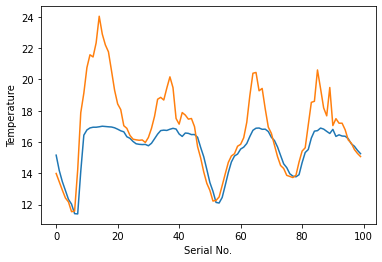

In [ ]:
plot_predictions1(model3,X1_test,Y1_test)

# Model 4
We will use LSTM but we will increase the number of inputs. We will take the datetime column as an input as well. 

But, we will convert the datetime column into 4 individual columns to better represent the periodicity of the timestamps (day and year wise). It will become clearer in next few code cells.

There is some theory about sin and cos of seconds. We are trying to create sin and cos signals out of the values of seconds.The reason has something to do with perioicity. The temperature at the end of the day is different from the middle so thats why we have sin day. And temp from December is different from June, so we have year sin and cos. All Decembers should be the same, all ends of the day should be similiar. This is to show similiarity between these times. This should wrap around.

In [ ]:
temp_df = pd.DataFrame({'Temperature':df['T (degC)'],'Date Time':df['Date Time']}) # creating a new dataframe 
temp_df['Seconds']=temp_df['Date Time'].map(pd.Timestamp.timestamp)
temp_df=temp_df.drop('Date Time',axis=1)
temp_df.head()

,Temperature,Seconds
5,-8.05,1.230772e+09
11,-8.88,1.230775e+09
17,-8.81,1.230779e+09
23,-9.05,1.230782e+09
29,-9.63,1.230786e+09


Now we will make the 4 new columns.

In [ ]:
day = 60*60*24 # seconds in a day
year = 365.2425 * day # seconds in a year

temp_df['Day_sin'] = np.sin(temp_df['Seconds'] * 2 * np.pi/day)
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df = temp_df.drop('Seconds',axis=1)
temp_df.head()

,Temperature,Day_sin,Day cos,Year sin,Year cos
5,-8.05,0.258819,0.965926,0.010049,0.999950
11,-8.88,0.500000,0.866025,0.010766,0.999942
17,-8.81,0.707107,0.707107,0.011483,0.999934
23,-9.05,0.866025,0.500000,0.012199,0.999926
29,-9.63,0.965926,0.258819,0.012916,0.999917


Now the input formatting needs to drastically change, each bracket should contain information on only 1 time stamp. Let's denote day sin by ds, day cos by dc and year sin and cos by ys and yc respectively. 
<br>

Then the format of the input needs to be-
```

[[[t1, ds1, dc1, ys1, yc1], [t2, ds2, dc2, ys2, yc2], [t3, ds3, dc3, ys3, yc3], [t4, ds4, dc4, ys4, yc4], [t5, ds5, dc5, ys5, yc5]]]      [t6]

```


Now we will have to make a custom input_formatter because the input format has changed.

In [ ]:
def input_formatter4(df,window_size=5):   # window size means how many of the consecutive previous values are you taking
  df_as_np = df.to_numpy() # converting dataframe to numpy
  X = []
  Y = []
  for i in range(len(df_as_np)-window_size):
    row=[r for r in df_as_np[i:i+window_size]]
    X.append(row)
    Y.append(df_as_np[i+5][0])
  return np.array(X), np.array(Y)

In [ ]:
X4, Y4 = input_formatter4(temp_df)
X4.shape, Y4.shape

((70086, 5, 5), (70086,))

The input, X_train, is always in this format
(no. of training samples, number of previous values, the no. of attributes we are using) <br>
So these are basically tensors.
Now dividing the data into training, validation and testing sets

In [ ]:
X4_train,Y4_train=X4[:60000], Y4[:60000]
X4_val, Y4_val = X4[60000:65000], Y4[60000:65000]
X4_test, Y4_test = X4[65000:], Y4[65000:]
print ("Shape of the training input = ", X4_train.shape)

Shape of the training input =  (60000, 5, 5)


In [ ]:
temp_df.head()

,Temperature,Day_sin,Day cos,Year sin,Year cos
5,-8.05,0.258819,0.965926,0.010049,0.999950
11,-8.88,0.500000,0.866025,0.010766,0.999942
17,-8.81,0.707107,0.707107,0.011483,0.999934
23,-9.05,0.866025,0.500000,0.012199,0.999926
29,-9.63,0.965926,0.258819,0.012916,0.999917


We see that temperature is in a different scale than the other 4 columns so we should normalize that.
There is a difference between standardization and normalization. Standardization makes a normal distribution curve. For that, we need mean and standard deviation of the distribution.
Standardization is Z-Score Normalization.

In [ ]:
temp_train_mean4 = np.mean(X4_train[:,:,0]) # We only want temperature attribute
temp_train_std4 = np.std(X4_train[:,:,0])

def preprocess4(X):
  # We are standardizing the distribution using this formula (x-mean)/std
  X[:,:,0] = (X[:,:,0] - temp_train_mean4) / temp_train_std4
  return X

In [ ]:
preprocess4(X4_train)
preprocess4(X4_val) # Note that to preprocess all data, we are taking mean and std of training set.
preprocess4(X4_test)

array([[[ 1.04010043e+00, -9.65925826e-01,  2.58819045e-01,
          5.22877889e-01, -8.52407598e-01],
        [ 9.90737068e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49698876e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55673415e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66349227e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01]],

       [[ 9.90737068e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49698876e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55673415e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66349227e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01],
        [ 5.37064219e-01, -7.16474371e-12,  1.00000000e+00,
  

In [ ]:
model4 = Sequential()
model4.add(InputLayer((5,5))) # Last 2 dimensions from X_train.shape (no. of previous values or timestamps, no. of variables)
model4.add(LSTM(64))
model4.add(Dense(8,'relu'))
model4.add(Dense(1,'linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp4 = ModelCheckpoint('model4/',save_best_only=True)
model4.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])

In [ ]:
model4.fit(X4_train, Y4_train, validation_data=(X4_val,Y4_val), 
          epochs=1, #How many runs it has had on the data
          callbacks=[cp4]) # To make sure it calls cp after evey epoch to see if the model should be saved or not.

1875/1875 [==============================] - 16s 7ms/step - loss: 33.8292 - root_mean_squared_error: 5.8163 - val_loss: 3.6663 - val_root_mean_squared_error: 1.9147


In [ ]:
model4 = load_model('model4/')

As the format of the output has not changed, we can still use the plot_predictions1 function.

(       Predictions  Actuals
 0        -1.762291    -9.67
 1        -1.786525    -9.17
 2        -1.793125    -8.10
 3        -1.788652    -7.66
 4        -1.771676    -7.04
 ...            ...      ...
 59995     3.550464     6.07
 59996     4.407929     9.88
 59997     5.684150    13.53
 59998     7.057270    15.43
 59999     9.226405    15.54
 
 [60000 rows x 2 columns], 6.669953195340337)

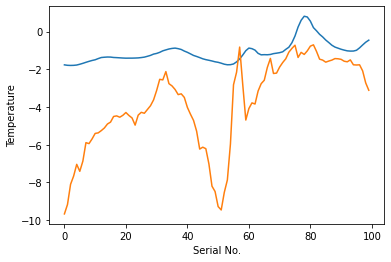

In [ ]:
plot_predictions1(model4,X4_train,Y4_train)

(      Predictions  Actuals
 0       11.144301    14.02
 1       13.222497    13.67
 2       14.156156    12.27
 3       13.711027    11.19
 4       12.387642    10.85
 ...           ...      ...
 4995    18.888268    18.27
 4996    17.917643    17.85
 4997    16.935253    16.65
 4998    15.939479    15.85
 4999    14.332647    15.09
 
 [5000 rows x 2 columns], 3.6662619882346386)

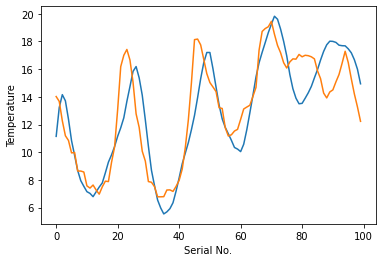

In [ ]:
plot_predictions1(model4,X4_val,Y4_val)

(      Predictions  Actuals
 0       13.783872    13.99
 1       13.214662    13.46
 2       12.668067    12.93
 3       12.473516    12.43
 4       12.483472    12.17
 ...           ...      ...
 5081     2.430585    -0.98
 5082     1.531858    -1.40
 5083     0.117860    -2.75
 5084    -0.508262    -2.89
 5085    -0.851925    -3.93
 
 [5086 rows x 2 columns], 4.754345991593774)

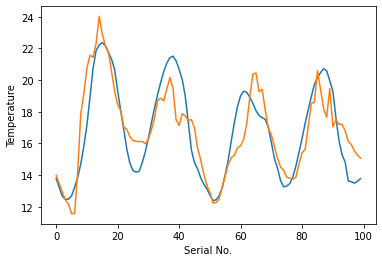

In [ ]:
plot_predictions1(model4,X4_test,Y4_test)

# Model 5
LSTM with multivariate input and ouput. We will be incorporating pressure column too.

In [ ]:
# Making a new df
p_temp_df = pd.concat([df['p (mbar)'],temp_df], axis=1)
p_temp_df.head()

,p (mbar),Temperature,Day_sin,Day cos,Year sin,Year cos
5,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,0.965926,0.258819,0.012916,0.999917


The format of the input has again changed thus the input formatter would need to be changed.

In [ ]:
def input_formatter5(df,window_size=5):   #window size means how many of the consecutive previous values are you taking
  df_as_np = df.to_numpy() #converting dataframe to numpy
  X = []
  Y = []
  for i in range(len(df_as_np)-window_size):
    row=[r for r in df_as_np[i:i+window_size]]
    X.append(row)
    Y.append([df_as_np[i+5][0], df_as_np[i+5][1]]) # adding pressure as a label now
  return np.array(X), np.array(Y)

In [ ]:
X5, Y5 = input_formatter5(p_temp_df)
X5.shape, Y5.shape

((70086, 5, 6), (70086, 2))

In [ ]:
X5_train,Y5_train=X5[:60000], Y5[:60000]
X5_val, Y5_val = X5[60000:65000], Y5[60000:65000]
X5_test, Y5_test = X5[65000:], Y5[65000:]
print ("Shape of the training input = ", X5_train.shape)

Shape of the training input =  (60000, 5, 6)


In [ ]:
p_temp_df.head()

,p (mbar),Temperature,Day_sin,Day cos,Year sin,Year cos
5,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,0.965926,0.258819,0.012916,0.999917


We will be standardizing the data as done in model 4.

In [ ]:
temp_train_mean5 = np.mean(X5_train[:,:,1]) # This is the same as temp_train_mean4 but still defined here for clarity
temp_train_std5 = np.std(X5_train[:,:,1])

p_train_mean5 = np.mean(X5_train[:,:,0]) # We only want pressure attribute that is 0th column
p_train_std5 = np.std(X5_train[:,:,0])

def preprocess5(X):
  # We are standardizing the distribution using this formula (x-mean)/std
  X[:,:,1] = (X[:,:,1] - temp_train_mean5) / temp_train_std5
  X[:,:,0] = (X[:,:,0] - p_train_mean5) / p_train_std5
  return X

Here we also decide to preprocess the output.

In [ ]:
def preprocess_output5(Y):
  Y[:, 1] = (Y[:, 1] - temp_train_mean5) / temp_train_std5
  Y[:, 0] = (Y[:, 0] - p_train_mean5) / p_train_std5
  return Y

In [ ]:
preprocess5(X5_train)
preprocess5(X5_val)
preprocess5(X5_test)

array([[[-1.07355724e+00,  1.04010043e+00, -9.65925826e-01,
          2.58819045e-01,  5.22877889e-01, -8.52407598e-01],
        [-1.00807546e+00,  9.90737068e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-9.51082068e-01,  8.49698876e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        [-9.14703306e-01,  7.55673415e-01, -5.00000000e-01,
          8.66025404e-01,  5.21043709e-01, -8.53529995e-01],
        [-8.80749794e-01,  6.66349227e-01, -2.58819045e-01,
          9.65925826e-01,  5.20431780e-01, -8.53903251e-01]],

       [[-1.00807546e+00,  9.90737068e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-9.51082068e-01,  8.49698876e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        [-9.14703306e-01,  7.55673415e-01, -5.00000000e-01,
          8.66025404e-01,  5.21043709e-01, -8.53529995e-01],
        [-8.80749794e-01,  6.6

In [ ]:
preprocess_output5(Y5_train)
preprocess_output5(Y5_val)
preprocess_output5(Y5_test)

array([[-0.82981953,  0.53706422],
       [-0.80192914,  0.47477235],
       [-0.79344076,  0.41248048],
       ...,
       [ 1.48144452, -1.43041855],
       [ 1.41596275, -1.44687301],
       [ 1.35048098, -1.56910611]])

In [ ]:
model5 = Sequential()
model5.add(InputLayer((5,6))) # Last 2 dimensions from X_train.shape (no. of previous values or timestamps, no. of variables)
model5.add(LSTM(64))
model5.add(Dense(8,'relu'))
model5.add(Dense(2,'linear')) # Notice how this has changed to 2 instead of 1 as we are predicting 2 variables now.

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 2)                 18        
                                                                 
Total params: 18,714
Trainable params: 18,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp5 = ModelCheckpoint('model5/',save_best_only=True)
model5.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])

In [ ]:
model5.fit(X5_train, Y5_train, validation_data=(X5_val,Y5_val), 
          epochs=1, #How many runs it has had on the data
          callbacks=[cp5]) # To make sure it calls cp after evey epoch to see if the model should be saved or not.

1875/1875 [==============================] - 16s 8ms/step - loss: 0.2915 - root_mean_squared_error: 0.5399 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1732


These functions are to convert the output back to celsius scale again.

In [ ]:
def postprocess_temp5(arr):
  arr = (arr*temp_train_std5) + temp_train_mean5
  return arr


def postprocess_p5(arr):
  arr = (arr*p_train_std5) + p_train_mean5
  return arr

Due to change in the format of the output, we need to make a new plot_predictions function.

In [ ]:
def plot_predictions5 (model, X, Y ,start=0, end=100):
  predictions = model.predict (X)
  p_preds, temp_preds= postprocess_p5(predictions [:, 0]), postprocess_temp5(predictions [:, 1])
  p_actuals, temp_actuals = postprocess_p5(Y[:, 0]), postprocess_temp5(Y[:, 1])
  df = pd.DataFrame (data={'Temperature Predictions': temp_preds,
                            'Temperature Actuals': temp_actuals,
                            'Pressure Predictions': p_preds,
                            'Pressure Actuals': p_actuals
                            })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df[start:end]

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,-7.882555,-9.67,996.475281,997.71
1,-7.964285,-9.17,996.672913,998.33
2,-7.907606,-8.10,996.976929,999.17
3,-7.733232,-7.66,997.323669,999.69
4,-7.530724,-7.04,997.753906,1000.27
...,...,...,...,...
95,-1.506033,-1.77,984.046936,985.57
96,-1.318646,-1.76,984.137085,985.97
97,-1.094604,-2.08,984.407898,986.79
98,-0.967840,-2.72,984.909729,987.67


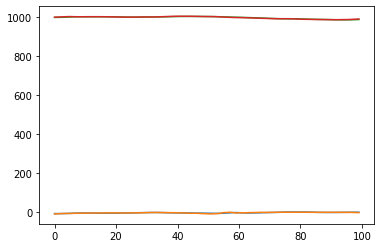

In [ ]:
plot_predictions5 (model5, X5_train, Y5_train)

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,14.287563,14.02,993.797424,993.96
1,14.775419,13.67,993.837463,994.08
2,14.418881,12.27,994.000854,994.38
3,13.252688,11.19,994.219604,994.65
4,11.767307,10.85,994.502747,994.60
...,...,...,...,...
95,16.850416,16.48,1000.807129,1000.79
96,16.666573,15.30,1000.421021,1000.44
97,16.088236,14.20,1000.035522,1000.05
98,15.206514,13.27,999.654358,999.73


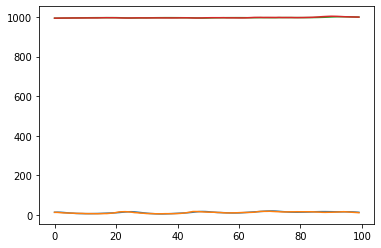

In [ ]:
plot_predictions5 (model5, X5_val, Y5_val)

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,14.514007,13.99,980.974365,982.13
1,13.887513,13.46,981.396851,982.36
2,13.334046,12.93,981.690308,982.43
3,12.969467,12.43,981.900330,982.68
4,12.744083,12.17,982.050903,983.02
...,...,...,...,...
95,14.533594,16.13,984.431396,985.42
96,14.291142,15.93,984.627441,985.50
97,14.100746,15.52,984.787170,985.54
98,14.072380,15.27,984.996643,985.68


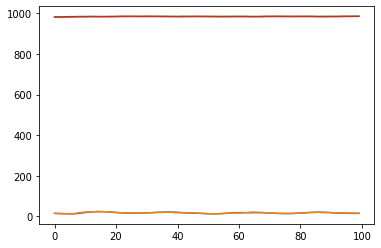

In [ ]:
plot_predictions5 (model5, X5_test, Y5_test)

# Comparision between the 5 models

Before we try to compare the above 5 models, let us try to understand the values on which we will compare them.
While training the model, we came across these values
<br>

*   No. of training Parameters
*   RMSE - a metric
*   Validation loss (val_loss)
*   loss function (mse selected while compiling the model)

<br>
Now what is the difference between a metric and loss function? <br>
The loss function is used to optimize your model. This is the function that will get minimized by the optimizer. A metric is used to judge the performance of your model. This is only for you to look at and has nothing to do with the optimization process.<br>
The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data.
<br>
No. of training parameters tells us about the complexity. RNNs will always be more complex than CNNs. 




In [ ]:
model_desc={"model1":"LSTM, input - temp, output - temp","model2":"Conv1D, input - temp, output - temp","model3":"GRU input - temp, output - temp","model4":"LSTM, input - temp + sin/cos of time, output - temp","model5":"LSTM, input - temp + pressure + sin/cos of time, output - temp + pressure"}
model_training = {"model1":"17425","model2":"2257","model3":"13393","model4":"18449","model5":"18714",}

For the sake of simplicity, let us compare RMSE values of training, validation and testing sets for all the models.

In [ ]:
eval = pd.DataFrame()
eval['Models'] = pd.DataFrame([i for i in model_desc])
eval['Description'] = pd.DataFrame([model_desc[i] for i in model_desc])
eval['No. of Training Parameters'] = pd.DataFrame([model_training[i] for i in model_training])
training_loss_rmse = [model1.evaluate(X1_train,Y1_train),model2.evaluate(X1_train,Y1_train),model3.evaluate(X1_train,Y1_train),model4.evaluate(X4_train,Y4_train),model5.evaluate(X5_train,Y5_train)]
validation_loss_rmse = [model1.evaluate(X1_val,Y1_val),model2.evaluate(X1_val,Y1_val),model3.evaluate(X1_val,Y1_val),model4.evaluate(X4_val,Y4_val),model5.evaluate(X5_val,Y5_val)]
testing_loss_rmse = [model1.evaluate(X1_test,Y1_test),model2.evaluate(X1_test,Y1_test),model3.evaluate(X1_test,Y1_test),model4.evaluate(X4_test,Y4_test),model5.evaluate(X5_test,Y5_test)]
eval['Training RMSE'] = [i[1] for i in training_loss_rmse]
eval['Validation RMSE'] = [i[1] for i in validation_loss_rmse]
eval['Testing RMSE'] = [i[1] for i in testing_loss_rmse]

159/159 [==============================] - 0s 2ms/step - loss: 0.0288 - root_mean_squared_error: 0.1697


In [ ]:
eval

,Models,Description,No. of Training Parameters,Training RMSE,Validation RMSE,Testing RMSE
0,model1,"LSTM, input - temp, output - temp",17425,2.098004,1.151176,2.216030
1,model2,"Conv1D, input - temp, output - temp",2257,2.235025,1.434341,1.364744
2,model3,"GRU input - temp, output - temp",13393,2.678962,1.288498,3.556966
3,model4,"LSTM, input - temp + sin/cos of time, output -...",18449,2.582626,1.914748,2.180447
4,model5,"LSTM, input - temp + pressure + sin/cos of tim...",18714,0.183245,0.173154,0.169682


We see the best model is the last one by far, LSTM with temperature, pressure and datetime inputs and we try to predict pressure as well temperature. 